<a href="https://colab.research.google.com/github/Chanura04/ML-Coursework/blob/main/20240955.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [2]:
!pip install keras-tuner 

In [3]:
import pandas as pd
# from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import keras_tuner as kt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras import layers, regularizers, optimizers, callbacks, models
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
import tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
import random
random.seed(SEED)
tf.random.set_seed(SEED)

## Load the dataset

In [4]:
url_x = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/processed/set_01/X.csv"
url_y = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/processed/set_01/y_data.csv"

## Check dataset behaviour

In [5]:
X=pd.read_csv(url_x)
y=pd.read_csv(url_y)
X.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,0,0,1,0,0,...,1,29.85,29.85,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,34,1,0,1,0,1,0,...,0,56.95,1889.50,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,0,0,2,1,0,1,1,0,0,...,1,53.85,108.15,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,0,45,0,0,1,0,1,1,...,0,42.30,1840.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0,0,2,1,0,0,0,0,0,...,1,70.70,151.65,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
X["TotalCharges"]

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [7]:
y.head()

,Churn
0,0
1,0
2,1
3,0
4,1


In [8]:
X.shape

(7043, 22)

In [9]:
y.shape

(7043, 1)

### Split Data into Training, Validation, and Test Sets

In [10]:
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_temp, y_train, y_temp= train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test= train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4930, 22)
Shape of y_train: (4930, 1)
Shape of X_val: (1056, 22)
Shape of y_val: (1056, 1)
Shape of X_test: (1057, 22)
Shape of y_test: (1057, 1)


In [11]:
np.sum(y_val==1)

c:\Users\chanu\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Churn    280
dtype: int64

In [12]:
np.sum(y_val==0)

Churn    776
dtype: int64

In [13]:
# Initialize the scaler
scaler = StandardScaler()

# FIT AND TRANSFORM the training data 
X_train = scaler.fit_transform(X_train)

# TRANSFORM the test data 
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [14]:
X_train[0]

array([-0.43814715, -0.96295739, -0.65086184, -1.11472828,  0.33445908,
       -0.85678685, -0.63699286, -0.73200106, -0.73265479, -0.64581257,
        1.2409383 , -0.80242214, -1.20529512,  0.50428615, -0.83787772,
        1.12453737, -0.52587133, -0.51517027, -0.5647009 , -0.52555704,
        1.40735673, -0.54312331])

In [15]:
y_train = y_train.squeeze()    
y_val   = y_val.squeeze()
y_test  = y_test.squeeze()

Text(0.5, 1.0, 'Count Plot for Churn')

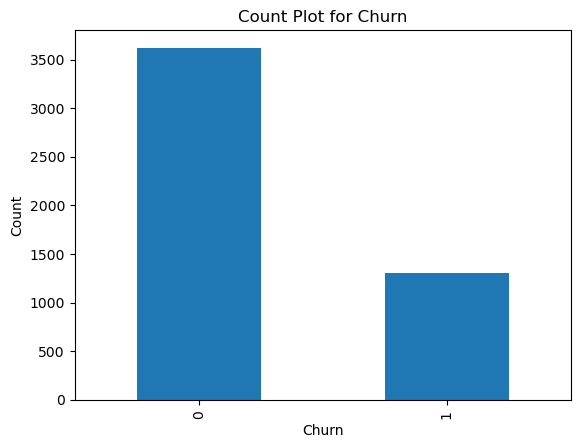

In [16]:
count=y_train.value_counts()
count.plot(kind='bar')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count Plot for Churn')

Text(0.5, 1.0, 'Count Plot for Churn')

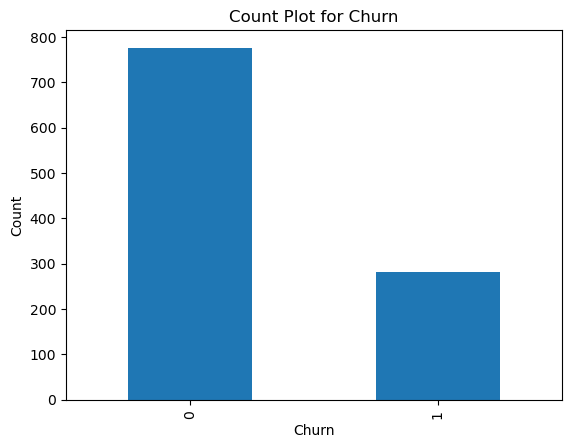

In [17]:
count=y_test.value_counts()
count.plot(kind='bar')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count Plot for Churn')

In [18]:
def plot_history(history):
    # Loss
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Binary Crossentropy")
    plt.legend()


    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()


    # AUC
    plt.subplot(1,3,3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title("AUC Curve")
    plt.xlabel("Epochs")
    plt.ylabel("AUC Score")
    plt.legend()
    plt.show()





## Train Neural Network

#### Experiment 01

In [19]:
input_dim=X_train.shape[1]
input_dim

22

In [20]:
# ,kernel_regularizer=keras.regularizers.l2(0.001) 

In [21]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

Class weights: {0: np.float64(0.680563224737714), 1: np.float64(1.8845565749235473)}


In [40]:
def make_baseline_model(input_dim):

    model = models.Sequential([
        layers.InputLayer(input_shape=(input_dim,)),        
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        

        
        layers.Dense(1, activation='sigmoid')
    ])

    return model

model=make_baseline_model(input_dim)
model.summary()


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name='auc'), 'accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')
            ]
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=16,
    verbose=2,
    class_weight=class_weight_dict

)

c:\Users\chanu\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
309/309 - 2s - 7ms/step - accuracy: 0.6357 - auc: 0.7047 - loss: 0.6271 - precision: 0.3920 - recall: 0.6774 - val_accuracy: 0.7140 - val_auc: 0.8156 - val_loss: 0.5641 - val_precision: 0.4768 - val_recall: 0.8071
Epoch 2/60
309/309 - 1s - 2ms/step - accuracy: 0.7205 - auc: 0.7999 - loss: 0.5478 - precision: 0.4827 - recall: 0.7485 - val_accuracy: 0.7216 - val_auc: 0.8264 - val_loss: 0.5404 - val_precision: 0.4850 - val_recall: 0.8107
Epoch 3/60
309/309 - 0s - 1ms/step - accuracy: 0.7375 - auc: 0.8193 - loss: 0.5222 - precision: 0.5035 - recall: 0.7745 - val_accuracy: 0.7244 - val_auc: 0.8299 - val_loss: 0.5344 - val_precision: 0.4883 - val_recall: 0.8179
Epoch 4/60
309/309 - 0s - 2ms/step - accuracy: 0.7406 - auc: 0.8264 - loss: 0.5120 - precision: 0.5071 - recall: 0.7875 - val_accuracy: 0.7225 - val_auc: 0.8321 - val_loss: 0.5297 - val_precision: 0.4860 - val_recall: 0.8071
Epoch 5/60
309/309 - 0s - 1ms/step - accuracy: 0.7363 - auc: 0.8311 - loss: 0.5040 - precision: 0.50

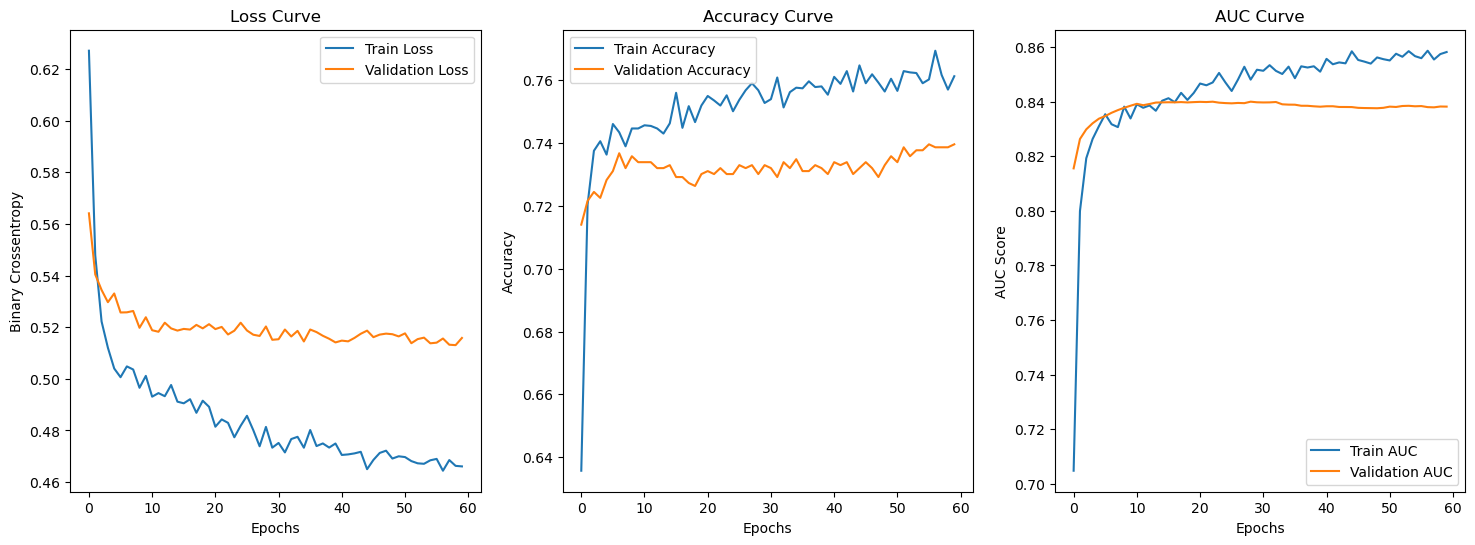

In [41]:
plot_history(history)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


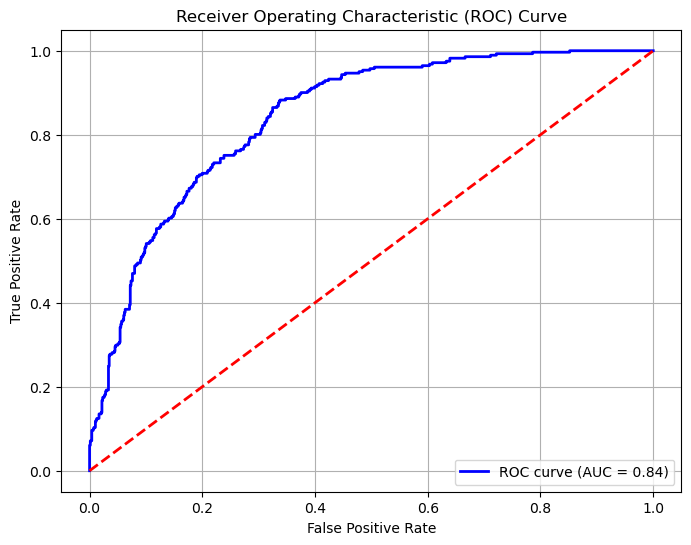

In [42]:
y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [43]:
test_results = model.evaluate(X_test, y_test, verbose=0)

print(f"Test AUC: {test_results[1]:.4f}")
print(f"Test Accuracy: {test_results[2]:.4f}")
print(f"Test Precision: {test_results[3]:.4f}")
print(f"Test Recall: {test_results[4]:.4f}")

print("Classification Report:")
print(classification_report(y_test, (model.predict(X_test) >= 0.5).astype(int)))

Test AUC: 0.8425
Test Accuracy: 0.7370
Test Precision: 0.5035
Test Recall: 0.7651
Classification Report:
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       0.90      0.73      0.80       776
           1       0.50      0.77      0.61       281

    accuracy                           0.74      1057
   macro avg       0.70      0.75      0.70      1057
weighted avg       0.79      0.74      0.75      1057



In [26]:
# os.makedirs("models", exist_ok=True)
#
# best_tuned_model_test_02.save("models/final_ann_model.keras")
